<a href="https://colab.research.google.com/github/marciusdm/dsnp/blob/main/projeto6_1/ProjetoRegressaoPyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [Marcius D. Moraes](https://github.com/marciusdm)*  

---

# Prevendo custos com seguro de saúde
<center>
  <img src="https://images.unsplash.com/photo-1454165804606-c3d57bc86b40?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=870&q=80"><br/>
  Foto de <a href="https://unsplash.com/pt-br/@homajob?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Scott Graham</a> na <a href="https://unsplash.com/pt-br/fotografias/5fNmWej4tAA?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
</center>

## 1. Apresentação
Neste projeto serão testados vários modelos de aprendizado de máquina para tentar prever o valor a ser pago para aquisição de um seguro de saúde, que no jargão das seguradoras é chamado de "prêmio".  
Mais uma vez será utilizado um conjunto de dados da plataforma [Kaggle](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fwww.kaggle.com%2Fannetxu%2Fhealth-insurance-cost-prediction). Infelizmente, não há informações sobre a origem destes dados, nem se são reais ou fictícios. O que se sabe é que é um conjunto de dados bastante simples com apenas 7 colunas, com algumas poucas informações que são: idade, sexo, índice de massa corporal, se fumante, número de filhos, local de moradia e o prêmio pago pelo cliente.  
É óbvio que o procedimento para chegar ao valor que o cliente deve pagar para ter direito a uma apólice é muito mais complexo. Normalmente eles têm de responder a um questionário detalhado no qual devem, entre outras coisasm informar se fazem algum tratamento médico, se já fizeram cirurgia, se já tiveram alguma doença grave, como câncer, ou se alguém da famúlia tem  problemas de saúde.  Entretanto, se o desempenho dos modelos a serem construídos forem satisfatórios, mesmo com estas poucas informações, então eles podem auxiliar as companhias de seguro a fazer os cálculos de prêmio de forma mais ágil.
## 2. Preparando o ambiente de execução
A primeira etapa consiste em importar todas as bibliotecas utilizadas neste projeto:



In [ ]:
# instalando a biblioteca
!pip install pycaret -q
!pip install pandas_profiling --upgrade -q

In [ ]:
#importando os pacotes necessários
import pandas as pd
import ydata_profiling as pf
from ipywidgets import interact, widgets, fixed

In [ ]:
# importando os pacotes necessários
from pycaret.regression import *

## 3. Análise exploratória dos dados.
Como é de praxe, vamos verificar a estrutura do conjunto de dados utilizado para alimenter os modelos de ML. Para isso será utilizada a boblioteca `pandas_profiling` para gerar um relatório de perfil do cojunto de de dados. Esta biblioteca permite visualizar várias informações relevantes no contexto do projeto, tais como distribuição dos valores, presença ou não de valores nulos e correlações entre as variáveis.


In [ ]:
#Importando os dados
df = pd.read_csv("https://github.com/marciusdm/dsnp/raw/main/assets/projeto6_1/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
# criar ProfileReport
report = pf.ProfileReport(df)

In [ ]:
# criar visualização iframe
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Pelo relatório acima pode-se extrair as seguintes informações:
* não existem valores nulos;
* como era de se esperar, a idade e o fato de ser fumante possuem uma forte influência no valor a ser pago pelo segurado. Já as outras variáveis, como sexo, índice de massa corporal e local de moradia têm um peso menor;
* mais da metade dos segurados possui um índice de massa corporal acima de 30, o que é considerado como obeso. Menos de 1/4 possui um índice de massa corporal considerado como o ideal, que é entre 20 e 25;
* a proporção entre homens e mulheres é bastante equilibrada;
* pouco mais 20% dos segurados é fumante. Uma tendência de queda ocasionada pela campanhas antitabagistas promovidas ao longo das últimas décadas;
* a maioria dos valores pagos é de no máximo \$10.000, apenas alguns seguros excedem os \$50.000.


## 4. Testando modelos de regressão
Para este projeto será utlizado o PyCaret, que é uma ferramenta poderosa que permite testar diversos modelos de *machine learning* com poucas linhas de código, além de executar as rotinas pré-processamento dos dados, tais como balanceamento, normalização e tratamento de valores nulos.
### 4.1 Dividindo o conjunto de dados
 Primeiramente será feita a divisão entre dados de treino e teste.



In [ ]:
# separando os dados em teste e treino
test = df.sample(frac=0.10,random_state=42)
train = df.drop(test.index)

test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)

In [ ]:
## Verificando os tamanhos dos conjuntos de dados
# verificando o formato dos conjuntos
print(train.shape)
print(test.shape)

(1204, 7)
(134, 7)


### 4.2 Fazendo o setup do PyCaret
A função `setup`abaixo configura o ambiente de execução do PyCaret e configura uma sequência de procedimentos que deixa os dados pronto para uso pelos modelos de aprendizado de máquina. Dois são os parâmetros obrigatórios deste método. O conjunto de dados e variável alvo, sobre a qual será feita as previsões.

In [ ]:
# configurando o ambiente
# O parâmetro session_id serve apenas para garantir que os resultados obtidos são sempre os mesmos a cada execução
reg = setup(data = train, target = 'charges', session_id=1)

,Description,Value
0,Session id,1
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1204, 7)"
4,Transformed data shape,"(1204, 10)"
5,Transformed train set shape,"(842, 10)"
6,Transformed test set shape,"(362, 10)"
7,Ordinal features,2
8,Numeric features,3
9,Categorical features,3


## 4.3 Comparando modelos
Agora serão testados diversos modelos de *machine learning* para regressão.
Isto é feito pelo método `compare_models()`, cuja saída é uma tabela com os vários modelos executados com as suas respectivas métricas de desempenho, que são:
* MAE - Mean Absolute Error mostra a média de erro em valores absolutos.
* MSE - Mean Squared Error, Erro Quadrático Médio
* RMSE - Root Mean Squared Error, Raiz do Erro Quadrático Médio
* R2 - Coefficient of Determination R2 Score
* RMSLE - Root Mean Squared Log Error
* MAPE - Mean Absolute Percentage Error mostra a média do erro absoluto em valores percentuais.

Mais detalhes sobre estas medidas de desempenho podem ser vistas neste [artigo](https://medium.com/turing-talks/como-avaliar-seu-modelo-de-regress%C3%A3o-c2c8d73dab96).

In [ ]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2577.1612,20799550.3398,4514.1541,0.8387,0.4253,0.3038,0.2230
lightgbm,Light Gradient Boosting Machine,2924.7716,23164033.0240,4773.9800,0.8194,0.5548,0.3701,0.7650
rf,Random Forest Regressor,2763.0873,23442262.4908,4808.4861,0.8175,0.4624,0.3303,0.3540
ada,AdaBoost Regressor,3805.3648,24990609.7174,4964.7464,0.8038,0.5850,0.6358,0.1150
xgboost,Extreme Gradient Boosting,3023.4540,26787994.0000,5133.1503,0.7934,0.5406,0.3803,0.1700
et,Extra Trees Regressor,2720.6561,26228116.0554,5089.8852,0.7934,0.4646,0.3020,0.5450
ridge,Ridge Regression,4195.8943,35854069.7016,5947.0936,0.7281,0.6463,0.4508,0.1010
br,Bayesian Ridge,4188.8856,35850364.0811,5946.7464,0.7280,0.6581,0.4497,0.1940
lar,Least Angle Regression,4181.6062,35845910.0489,5946.3584,0.7279,0.6573,0.4485,0.1020
llar,Lasso Least Angle Regression,4181.6342,35842505.0006,5946.0766,0.7279,0.6566,0.4485,0.1020


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

GradientBoostingRegressor(random_state=1)

Por padrão, o método `compare_models`acima ordena os métodos de machine learning pelo R2, do melhor para o pior, mas isto pode ser mudado especificando-se o parâmetro `sort` com a medida de desempenho desejada. Também é possível modificar parâmetros diversos, tais como a quantidade de dobrar para validação cruzada (padrão 10), entre outras. Para mais informações consulte a [documentação](https://pycaret.readthedocs.io/en/latest/api/regression.html#pycaret.regression.compare_models) do Pycaret

O melhor modelo foi o Gradient Boosting Regressor. Na próxima etapa vamos instanciar este modelo e fazer ajuste fino dos parâmetros.
## 5. Criando uma instância do modelo Gradient Boosting Regressor (GBR)
Nesta etapa será criada uma instância do modelo que se saiu melhor entre todos os testados no estágio anterior.   
O melhor modelo foi o Gradient Boosting, uma técnica do tipo *ensemble*, que utiliza métodos aprendizes fracos que combinados produzem um aprendiz forte. Para isso, cada método 'fraco' é executado em sequência e tenta reduzir o erro gerado pelo método executado anteriormente, tendo como referência uma medida denominada de erro residual.  
Primeiramente vamos criar o modelo. Para isto utilizamos o método `create_model` passando como parâmetro um código,  que identifica o método (no caso do Gradient Boosting é `'gbr'`)


In [ ]:
# criar modelo
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2466.8295,18823895.4788,4338.6513,0.7871,0.4548,0.3407
1,2300.1132,14705094.8845,3834.7223,0.8975,0.3969,0.3058
2,2074.7659,13061711.1641,3614.0989,0.8465,0.3505,0.2521
3,2751.8576,24946234.0181,4994.6205,0.7976,0.3667,0.2668
4,2719.9385,20469972.4877,4524.3754,0.8711,0.4194,0.3082
5,2283.4710,15673159.0990,3958.9341,0.9125,0.3477,0.2332
6,3216.3741,34683893.2847,5889.3033,0.7432,0.5924,0.3652
7,2480.0648,17867415.9887,4226.9866,0.9184,0.4164,0.3025
8,2985.9939,26434642.0355,5141.4630,0.8015,0.4425,0.3404


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Ao invocar este método, é aplicada validação cruzada, e o modelo é executado tantas vezes quanto o número de dobras, que por padrão é 10, mas isto pode ser alterado especificando-se o parâmetro `fold`. Por exemplo, para definir 5 dobras invoca-se o método `create_model('gbr',fold=5)`. A saída deste método é uma tabela com os indicadores de cada execução.

## 6. Executando um ajuste fino do modelo
O PyCaret permite também ajustar o modelo escolhido para encontrar a melhor combinação de hiperparâmetros. Para isto será invocado o método `tune_model`. Por padrão ele é configurado para otimizar o R2, mas caso queira utilizar outra medida, basta definir o parâmetro `optimize`. Por exemplo em `tune_model(model,optimize='RMSE')` a otimização será feita pelo RMSE (Raiz do erro quadrático médio). Este método recebe como parâmetro o objeto criado pelo método `create_model` acima.

In [ ]:
tuned_gbr = tune_model(gbr, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2627.3498,21184490.1330,4602.6612,0.7604,0.4747,0.3438
1,2431.1683,16889067.2700,4109.6310,0.8823,0.4119,0.3077
2,2430.4063,15804902.5202,3975.5380,0.8143,0.3963,0.3106
3,3077.3602,28944238.5555,5379.9850,0.7652,0.4147,0.3072
4,2864.7710,21290807.4254,4614.1963,0.8659,0.4735,0.3789
5,2309.2314,15582135.3195,3947.4214,0.9130,0.4021,0.2428
6,3555.3703,36926478.3540,6076.7161,0.7266,0.6318,0.4247
7,2703.7711,20357468.1813,4511.9251,0.9070,0.4074,0.2808
8,3251.1967,28145907.1464,5305.2716,0.7886,0.4911,0.3897


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


## 7. Testando outros modelos.
Como o ajuste fino do modelo *gradient boosting* não gerou resultados melhores, será feito um teste com outros modelos. No caso, iremos pegar o segundo e o terceiro colocado obtido pelo `compare_models`, que são, respectivamente o Random Forest e o Light Gradient Boosting.
### 7.1. Instanciando os modelos

In [ ]:
rf = create_model('rf')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2588.3985,22252881.6571,4717.2960,0.7483,0.4257,0.3315
1,2334.8335,17397162.5774,4170.9906,0.8788,0.3898,0.2714
2,2494.9742,16860946.6569,4106.2083,0.8019,0.4078,0.3022
3,3015.1653,27434520.5077,5237.7973,0.7774,0.4108,0.2901
4,2915.2815,22720121.7331,4766.5629,0.8569,0.4951,0.4001
5,2397.4001,16989052.3917,4121.7778,0.9052,0.4228,0.2831
6,3259.8365,34739029.3350,5893.9825,0.7428,0.6031,0.4065
7,2836.1447,22386958.2791,4731.4858,0.8978,0.4617,0.3298
8,3310.0441,30065550.3651,5483.2062,0.7742,0.4996,0.3871


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2883.5347,23146322.0215,4811.0625,0.7382,0.6720,0.4049
1,2489.0030,17220407.2311,4149.7479,0.8800,0.4414,0.3082
2,2548.7465,15835337.0127,3979.3639,0.8140,0.4190,0.3350
3,3104.9249,28386291.5535,5327.8787,0.7697,0.4846,0.3584
4,2985.2108,20319849.6188,4507.7544,0.8720,0.4793,0.4177
5,2792.6599,16885337.0392,4109.1772,0.9057,0.5542,0.3414
6,3612.0406,37197759.4557,6098.9966,0.7246,0.7814,0.4885
7,2995.3076,22693835.8885,4763.8048,0.8964,0.4953,0.3494
8,3113.4237,26299731.9069,5128.3264,0.8025,0.6981,0.3773


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### 7.2 Executando ajuste fino
Nesta etapa será feito uma otimização dos hiperparâmetros para os modelos `RandomForest`e o `LightGradientBoosting`

In [ ]:
tuned_rf = tune_model(rf, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2625.3281,20057651.5717,4478.5770,0.7731,0.5026,0.4696
1,2448.6827,15753188.1410,3969.0286,0.8902,0.4200,0.3498
2,2126.8768,13096682.1258,3618.9338,0.8461,0.4018,0.3054
3,3125.7579,27462736.5050,5240.4901,0.7772,0.4774,0.3978
4,2470.1727,17882623.6987,4228.7851,0.8874,0.3982,0.2958
5,2557.2144,16847556.2524,4104.5775,0.9059,0.4161,0.3384
6,3336.2089,34784867.2296,5897.8697,0.7424,0.6162,0.4621
7,2631.3477,18571377.1658,4309.4521,0.9152,0.4732,0.3651
8,3014.8226,27540642.1817,5247.9179,0.7932,0.4480,0.3454


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
print(tuned_rf)

RandomForestRegressor(max_depth=3, min_impurity_decrease=0.0005,
                      min_samples_leaf=5, min_samples_split=10,
                      n_estimators=300, n_jobs=-1, random_state=1)


In [ ]:
tuned_lightgbm = tune_model(lightgbm, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2858.4433,20258394.1294,4500.9326,0.7708,0.5200,0.5192
1,2543.4989,17027989.2813,4126.4984,0.8813,0.4289,0.3723
2,2246.0820,13471089.8775,3670.2983,0.8417,0.4116,0.3345
3,3205.4843,28616596.7335,5349.4483,0.7678,0.4660,0.3914
4,2637.8561,19969061.7139,4468.6756,0.8743,0.4244,0.3207
5,2690.3584,16546264.4917,4067.7100,0.9076,0.4038,0.3402
6,3620.0552,36897357.9790,6074.3195,0.7268,0.6449,0.5142
7,3252.8204,21110677.9221,4594.6358,0.9036,0.4810,0.4308
8,3233.6688,25339652.0606,5033.8506,0.8097,0.4757,0.4273


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
print(tuned_lightgbm)

LGBMRegressor(bagging_fraction=0.5, bagging_freq=7, feature_fraction=0.5,
              learning_rate=0.05, min_child_samples=1, min_split_gain=0.5,
              n_estimators=120, n_jobs=-1, num_leaves=4, random_state=1,
              reg_alpha=10, reg_lambda=0.05)


Após a fazer o ajuste fino dos dois métodos acima, verifica-se que o método Random Forest se saiu melhor. Por isso, será o escolhido para fazer a validação final. Mas antes disso, vamos fazer uma avaliação do modelo
## 8. Avaliação interativa do modelo Random Forest
Iremos agora fazer um sumário do modelo que teve o melhor desempenho, mostrando diversos gráficos para isso.

In [ ]:
def plot_graphs(estimator, plot):
  plot_model(estimator, plot=plot)

In [ ]:
## Decidi não usar o método evaluate_model, pois existem alguns gráficos que demoram vários minutos para serem gereados e também há gráficos que não são
## suportados pelo modelo mais eficiente. Então juntei aqui os gráficos mais simples e fiz separado os que demandam mais tempo de geração.
options = ['pipeline',  'parameter',  'feature', 'error', 'manifold',   'vc' ,
                                         'residuals' , 'cooks' #, 'tree'
          ]
labels = ["Pipeline","HiperParameters","Feature Importance", "Prediction Error","Manifold Learning","Validation Curve" ,
          "Residuals Plot" , "Cooks Distance Plot" #,"Decision Tree"
          ]
tb = widgets.ToggleButtons(

            description="Tipo de gráfico:",
)

interact(
            plot_graphs,
            estimator=fixed(tuned_rf),
            plot = [ (l,o) for l,o in zip(labels, options) ],
)

interactive(children=(Dropdown(description='plot', options=(('Pipeline', 'pipeline'), ('HiperParameters', 'par…

<function __main__.plot_graphs(estimator, plot)>

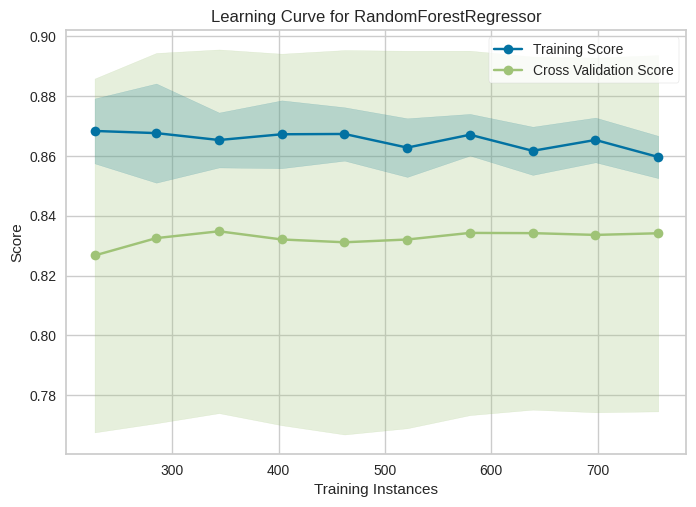

In [ ]:
plot_model(tuned_rf,plot="learning")

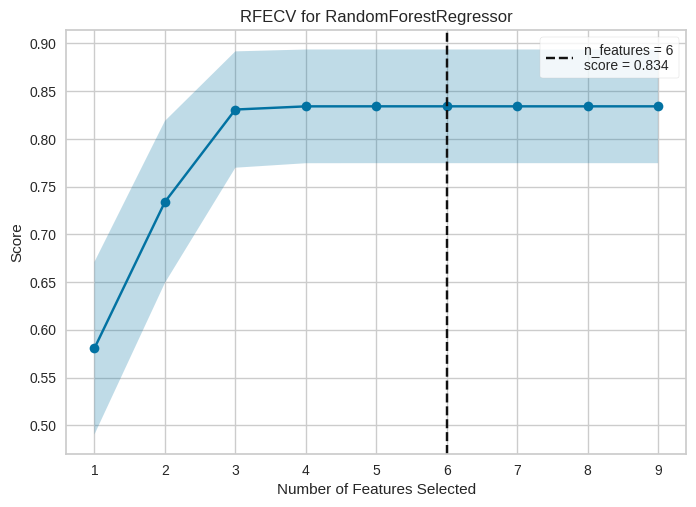

In [ ]:
plot_model(tuned_rf,plot="rfe")

In [ ]:
plot_model(tuned_rf, plot="tree")

## 9. Fazendo previsões
Agora, chegou o momento de testar nosso modelo escolhido, para fazer previsões nos dados que foram separados logo no começo do projeto e com os quais o modelo ainda não teve contato. Mas antes, faremos uma verificação final com intuido de medier novamente as métricas de desempenho e comparar com  aquelas obtidas durante a validação cruzada. Após será feita uma uma operação que é conhecida como "finalização do modelo", que basicamente, faz o treinamento do modelo em todo o conjunto de testes antes de colocá-lo em produção.
### 9.1 Verificação final






In [ ]:
predict_model(tuned_rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2666.5855,20839366.0011,4565.0154,0.8660,0.4175,0.3191


,age,sex,bmi,children,smoker,region,charges,prediction_label
636,49,male,28.690001,3,no,northwest,10264.442383,9987.990064
306,50,male,32.299999,1,yes,northeast,41919.097656,43911.668370
785,42,male,24.860001,0,no,southeast,5966.887207,5851.159080
49,58,female,31.825001,2,no,northeast,13607.369141,13832.179095
65,53,female,28.100000,3,no,southwest,11741.725586,13788.569081
...,...,...,...,...,...,...,...,...
73,31,male,26.885000,1,no,northeast,4441.213379,5980.857708
117,38,male,34.700001,2,no,southwest,6082.404785,7168.160400
1077,41,male,33.549999,0,no,southeast,5699.837402,5851.159080
866,51,male,24.795000,2,yes,northwest,23967.382812,24635.449053


O R2 do conjunto de testes ficou em 0.866, não muito diferente do R2 da validação cruzada, que ficou em 0,834
### 9.2. Finalizando o modelo

In [ ]:
final_model = finalize_model(tuned_rf)

### 9.3 Fazendo previsões em dados novos
Agora sim chegou a hora de testar nosso modelo nos dados de teste inicial:

In [ ]:
# previsão em dados não vistos
unseen_predictions = predict_model(final_model, data=test)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2657.7695,22056504.8105,4696.4353,0.8597,0.4362,0.3270


,age,sex,bmi,children,smoker,region,charges,prediction_label
0,27,female,24.100000,0,no,southwest,2974.125977,5194.294702
1,51,male,31.635000,0,no,northwest,9174.135742,10720.908289
2,27,female,25.174999,0,no,northeast,3558.620361,5194.294702
3,37,male,30.799999,0,no,southwest,4646.758789,5852.241534
4,47,female,29.545000,1,no,northwest,8930.934570,10475.400891


O R2 aplicado os dados não vistos anteriormente ficou em 0,8597. Um pouco abaixo do obtido no conjunto de testes, mas não é uma diferença significativa. O que signfico que nosso modelo é capaz de prever razoavelmente o valor dos prêmios dos seguros.

## 10. Etapa final: salvando o modelo
Por fim, iremos salvar nosso modelo de modo a utilizá-lo posteriormente para novas previsões. A biblioteca PyCaret inclusive oferece suporte para as plataformas AWS, Google Cloud e Microsoft Azure, permitindo salvar seu modelo em nuvem.

In [ ]:
# salvando o modelo
save_model(final_model,'Modelo_Final_2023_08_15')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['age', 'bmi', 'children'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['sex', 'smoker', 'region'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['sex', 'smoker...
                                                                          'mapping': no     0
 yes    1
 NaN   -1
 dtype: int64}]))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['region'],
                                     transformer=OneHotEncoder(cols=['region'],
                                                               handle_missing='return_nan',
                                                            

## 11. Conclusão
A bibilioteca PyCaret simplica bastante o processo de criar e testar modelos de *machine learning*. Tarefas que demandariam muitas linhas de código são feitas com poucos comandos, dando agilidade à execução de projetos de *data science*, embora existam algumas limitações.